Estructura de la sesión:
- Ajuste de hiperparámetros en los árboles de decisión
- Combinar el ajuste de hiperparámetros y la evaluación de modelos
  - GridSearch
  - RandomSearch
  - Optimización basada en modelos



# HIPERPARÁMETROS DE LOS ÁRBOLES DE DECISIÓN. AJUSTE DE ÁRBOLES DE DECISIÓN

- **max_depth : int or None, opcional (por defecto=None)**
    La profundidad máxima del árbol. Si es None, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos muestras que min_samples_split. Se ignora si max_leaf_nodes no es None.
    
- **min_samples_split : int, opcional (por defecto=2)**
    El número mínimo de muestras necesarias para dividir un nodo interno.

- Hay más parámetros:
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



Primero, se cargan los datos, las entradas van a X, las salidas a y.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
from scipy.stats import sem

housing_meta = fetch_california_housing()
X = housing_meta.data
y = housing_meta.target

print(housing_meta.DESCR)

## COMBINAR EL AJUSTE DE HIPERPARÁMETROS Y LA EVALUACIÓN DE MODELOS

La combinación de evaluación de modelos y ajuste de hiperparámetros puede entenderse como un bucle externo (outer) que entrena un modelo y prueba el modelo, y un bucle interno (inner), donde el proceso de entrenamiento consiste en buscar los mejores hiperparámetros, y luego obtener el modelo con esos mejores hiperparámetros.

En primer lugar, vamos a utilizar **Holdout** (entrenar/probar) para la evaluación del modelo (bucle externo o **outer**), y **3-fold crossvalidation** para el ajuste de los hiperparámetros (bucle interno o **inner**). Los hiperparámetros se ajustarán con **Gridsearch**.

#### GRIDSEARCH

En primer lugar, definamos nuestra función python para el RMSE

In [ ]:
from sklearn import metrics

def rmse(y_test, y_test_pred):
  """ This is my computation of Root Mean Squared Error """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [ ]:
from sklearn.model_selection import train_test_split

# Holdout for model evaluation. 33% of available data for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

En primer lugar, recordemos el RMSE con hiperparámetros por defecto

In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor()
np.random.seed(42)
regr.fit(X=X_train, y=y_train)
print(f"RMSE of tree with default hyper-pars: {rmse(y_test, regr.predict(X=X_test))}")


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression


# Search space

param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
regr = GridSearchCV(DecisionTreeRegressor(),
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner,
                   n_jobs=1, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (grid-search): {rmse(y_test, regr.predict(X=X_test))}")

Veamos los mejores hiperparámetros y su puntuación (MSE). Podemos ver que están cerca de los extremos del espacio de parámetros, pero no en el extremo.

In [ ]:
regr.best_params_, -regr.best_score_

#### BUSQUEDA ALEATORIA (RANDOMIZED SEARCH)

Ahora, utilicemos **Búsqueda aleatoria** en lugar de gridsearch. Sólo se probarán 20 combinaciones de valores de hiperparámetros (budget=20)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

# Inner evaluation
inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search): {rmse(y_test, regr.predict(X=X_test))}")

In [ ]:
regr.best_params_, -regr.best_score_

Para la **Búsqueda Aleatoria**, podemos definir el espacio de búsqueda con distribuciones estadísticas, en lugar de utilizar valores particulares como hacíamos antes. A continuación puedes ver cómo utilizar una distribución uniforme sobre enteros entre 2 y 16 mediante *randint*. Para hiperparámetros continuos podríamos usar distribuciones continuas como *uniform* o *expon* (exponencial).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search II): {rmse(y_test, regr.predict(X=X_test))}")

In [ ]:
regr.best_params_, -regr.best_score_

¿Y si quisiéramos hacer **evaluación de modelos con 5-fold crossvalidation** y **ajuste de hiperparámetros con 3-fold crossvalidation**? Esto se denomina validación cruzada anidada https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). Hay un bucle externo (para evaluar los modelos) y un bucle interno (para ajustar los hiperparámetros)

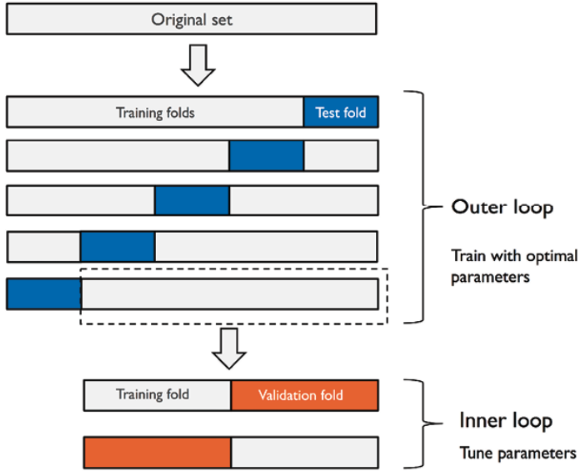

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=42 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy.stats import uniform, expon

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=2, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         # 3-fold for hyper-parameter tuning
                         cv=inner,
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr,
                            X, y,
                            scoring='neg_mean_squared_error',
                            cv = outer)

In [ ]:
print(scores)
# The score was MSE, we want RMSE
scores = np.sqrt(scores)
# The mean of the 5-fold crossvalidation is the final score of the model
print(f"{scores.mean()} +- {scores.std()}")

#### OBTENCIÓN DEL MODELO FINAL (PARA SU DESPLIEGUE, O PARA ENVIARLO A UN CONCURSO, ...)

Si necesitamos un modelo final, podemos obtenerlo ajustando regr a todos los datos disponibles. Recordemos que regr hace ajuste de hiper-parámetros.

In [ ]:
np.random.seed(42)

# Fitting again the randomized search HPO
regrFinal = regr.fit(X,y)

In [ ]:
regr.best_params_, -regr.best_score_

### OPTIMIZACIÓN BASADA EN MODELOS (BAYESIAN OPTIMIZATION - OPTUNA)

OPTUNA es un paquete externo a Scikit-Learn que proporciona un framework de optimización bayesiano para la optimización de hiperparámetros: https://optuna.org/. El framework proporciona un paquete específico llamado optuna-integration (https://optuna-integration.readthedocs.io/en/latest/), que permite aprovechar la búsqueda automatizada de Optuna con algoritmos eficientes preservando la estructura de codificación que estamos utilizando basada en Scikit-Learn.
En este tutorial, exploraremos **Holdout** para la evaluación de modelos y **3-fold crossvalidation** para el ajuste de hiperparámetros (con **Optuna Hyperparameter Optimization**).

In [ ]:
#Para acceder a diferentes distribuciones y otros métodos
%pip install optuna
#Para acceder a optuna.integration.OptunaSearchCV y permitir la integración con Scikit-Learn
%pip install --upgrade optuna-integration[sklearn]

In [ ]:
#import optuna.integration
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution as IntDist
from sklearn import metrics
from sklearn.model_selection import KFold

# Search space with integer uniform distributions
param_grid_optuna = {'max_depth': IntDist(2,30),
                     'min_samples_split': IntDist(20,100)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)
budget = 50
regr = OptunaSearchCV(DecisionTreeRegressor(),
                    param_grid_optuna,
                    scoring='neg_mean_squared_error',
                    n_trials=budget,
                    cv=inner,
                    n_jobs=1, verbose=1,
                    timeout=600,
                    random_state=42
                    )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by bayessearch
# and trained on the complete X_train

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (Optuna optimization): {rmse(y_test, regr.predict(X=X_test))}")

In [ ]:
regr.best_params_, -regr.best_score_

Podemos comprobar si la optimización ha convergido

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
fig = plt.figure(figsize=(25,20))
trial = regr.study_
plot_optimization_history(trial)
plt.show()

También podemos visualizar la importancia de los distintos parámetros y el modelo final.

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances
fig = plt.figure(figsize=(25,20))
trial = regr.study_
plot_param_importances(trial)
plt.show()